In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
from pycaret.classification import setup, compare_models
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer, IterativeImputer
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE


# LOS MODELOS SON ACUMULADOS, ES DECIR, PRIMERO REALIZO UN MODELO SIMPLE, CON UNA LIMPIEZA DE DATOS, EN MODELOS POSTERIORES TOMO DECISIONES QUE AÑADO AL MODELO ANTERIOR (SIEMPRE Y CUANDO EL MODELO ANTERIOR PROPORCIONE UN BUEN RESULTADO), POR ELLO LOS DF QUE COJO EN MODELOS POSTERIORES AL 1 SON DF YA PREPROCESADOS DE LOS MODELOS ANTERIORES.

In [3]:
df_train_x= pd.read_csv('DATOS/train_x.csv')
train_y= pd.read_csv('DATOS/train_y.csv')
df_test_x= pd.read_csv('DATOS/test_x.csv')

In [3]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [4]:
train_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.3+ KB


In [5]:
df_test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13980 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

# ---------------------------PRIMER MODELO--------------------------- (0.8168)

# PREPROCESADO

### Juntamos test_x y train_x para realizar la limpieza más rápido

In [4]:
df_test_train = pd.concat([df_train_x,df_test_x], axis=0)
df_test_train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14846,18990,1000.0,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
14847,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,0,...,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe
14848,33492,0.0,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


### Observamos cuantos nulos hay en nuestro DF y en qué variables.

In [5]:
df_test_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    4507
gps_height                   0
installer                 4532
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4847
scheme_name              36052
permit                    3793
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

### En un primer momento vamos a sustituir los valores nulos por la moda de cada variable de nulos.


In [6]:
df_test_train[['permit','scheme_name','scheme_management','public_meeting','subvillage','installer','funder','wpt_name']].describe()

,permit,scheme_name,scheme_management,public_meeting,subvillage,installer,funder,wpt_name
count,70457,38198,69403,70095,73780,69718,69743,74248
unique,2,2867,11,2,21425,2410,2139,45683
top,True,K,VWC,True,Shuleni,DWE,Government Of Tanzania,none
freq,48606,858,45917,63749,646,21751,11299,4440


In [7]:
df_test_train['permit'] = df_test_train['permit'].replace({None: True})
df_test_train['scheme_name'] = df_test_train['scheme_name'].replace({None: 'K'})
df_test_train['scheme_management'] = df_test_train['scheme_management'].replace({None: 'VWC'})
df_test_train['public_meeting'] = df_test_train['public_meeting'].replace({None: True})
df_test_train['subvillage'] = df_test_train['subvillage'].replace({None: 'Shuleni'})
df_test_train['installer'] = df_test_train['installer'].replace({None: 'DWE'})
df_test_train['funder'] = df_test_train['funder'].replace({None: 'Government Of Tanzania'})
df_test_train['wpt_name'] = df_test_train['wpt_name'].replace({None: 'none'})

### Comprobamos que hemos transformado todos los valores nulos.

In [8]:
df_test_train.isnull().sum()

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
s

### Tenemos dos variables relacionadas con el tiempo, el date_recorder que determina la fecha en la que se agregó el valor, y la fecha de construcción de la bomba (construction_year), podríamos pensar que la antigüedad de la bomba es un factor que puede afectar a la funcionalidad de la misma, por tanto vamos a establecer una nueva variable que será la vida de la bomba (definida como la diferencia entre la construcción y el date_recorder)


In [9]:
df_test_train['date_recorded'].unique()

array(['2011-03-14', '2013-03-06', '2013-02-25', '2013-01-28',
       '2011-07-13', '2011-03-13', '2012-10-01', '2012-10-09',
       '2012-11-03', '2011-08-03', '2011-02-20', '2013-02-18',
       '2012-10-14', '2013-03-15', '2012-10-20', '2011-08-04',
       '2011-07-04', '2011-09-04', '2011-07-22', '2011-02-22',
       '2011-02-27', '2013-02-10', '2011-10-04', '2013-11-03',
       '2013-01-21', '2013-01-16', '2011-07-11', '2013-03-05',
       '2013-03-16', '2011-03-23', '2011-03-16', '2013-03-19',
       '2011-03-11', '2011-02-23', '2013-03-28', '2011-07-16',
       '2011-03-27', '2013-02-11', '2013-10-03', '2011-03-12',
       '2011-07-07', '2013-01-15', '2013-03-18', '2012-10-22',
       '2013-02-05', '2011-07-27', '2011-04-04', '2013-02-21',
       '2011-08-18', '2011-07-31', '2011-08-01', '2011-07-14',
       '2013-02-22', '2013-07-03', '2013-08-03', '2013-01-22',
       '2011-03-22', '2013-05-03', '2013-01-19', '2013-02-09',
       '2011-01-04', '2013-02-04', '2011-03-05', '2011-

In [10]:
df_test_train['construction_year'].value_counts()
df_test_train['construction_year'] = df_test_train['construction_year'].replace({0:2010})

### Vemos que en la variable constructoin_year hay valores 0, lo cual no puede ser posible, podríamos hacer dos tratamientos diferentes de datos: 
    1. Podemos sustituir el cero por la moda de las variables (esto solo es posible en caso de que no queramos hacer ninguna operación con la variable date_recorded, ya que sino podría salirnos valores negativos, ya que podría ocurrir que nuestro date_recorded sea inferior a nuestro construction_year, puesto que existen valores de date_recorded inferiores a la moda de la variable construction_year.
    2. Podemos susituir el cero por el valor máximo de las variables (en caso de que queramos ver el tiempo de vida de la bomba de agua, calculada como la diferencia entre el date_recorded y el construction_year, el problema en este caso es que estoy asumiendo un valor que no es real para muchos valores, ya que el valor cero se repite casi 26.000 veces)

### Vamos a sustituir los valores cero por la moda, ya que la segunda opción que busca encontrar una variable que defina el tiempo de vida de una bomba con su posibilidad o no de funcionamiento, se encontraría sesgada por nuestra decisión de transformar casi un tercio de los valores por el valor máximo, en todo caso, siempre podríamos hablar con negocio para preguntar las preferencias del mismo en función de los datos que estos puedan tener.


In [11]:
df_test_train['construction_year'].unique()

array([1999, 2010, 2009, 1986, 2011, 1987, 1991, 1978, 1992, 2008, 1974,
       2000, 2002, 2004, 1972, 2003, 1980, 2007, 1973, 1985, 1970, 1995,
       2006, 1962, 2005, 1997, 2012, 1996, 1977, 1983, 1984, 1990, 1982,
       1976, 1988, 1989, 1975, 1960, 1961, 1998, 1963, 1971, 1994, 1968,
       1993, 2001, 1979, 1967, 2013, 1969, 1981, 1964, 1966, 1965],
      dtype=int64)

In [12]:
to_factor = list(df_test_train.loc[:,df_test_train.nunique() <= 10])
df_test_train[to_factor] = df_test_train[to_factor].astype('category')

In [13]:
df_test_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74250 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     74250 non-null  int64   
 1   amount_tsh             74250 non-null  float64 
 2   date_recorded          74250 non-null  object  
 3   funder                 74250 non-null  object  
 4   gps_height             74250 non-null  int64   
 5   installer              74250 non-null  object  
 6   longitude              74250 non-null  float64 
 7   latitude               74250 non-null  float64 
 8   wpt_name               74250 non-null  object  
 9   num_private            74250 non-null  int64   
 10  basin                  74250 non-null  category
 11  subvillage             74250 non-null  object  
 12  region                 74250 non-null  object  
 13  region_code            74250 non-null  int64   
 14  district_code          74250 non-null  int6

In [13]:
col_obj = df_test_train.select_dtypes(include=['object']).columns

In [14]:
for col in col_obj:
    print(f"Características de la columna {col}:")
    print(df_test_train[col].describe())
    print("-" * 50)

Características de la columna date_recorded:
count          74250
unique           369
top       2011-03-17
freq             695
Name: date_recorded, dtype: object
--------------------------------------------------
Características de la columna funder:
count                      74250
unique                      2139
top       Government Of Tanzania
freq                       15806
Name: funder, dtype: object
--------------------------------------------------
Características de la columna installer:
count     74250
unique     2410
top         DWE
freq      26283
Name: installer, dtype: object
--------------------------------------------------
Características de la columna wpt_name:
count     74250
unique    45683
top        none
freq       4442
Name: wpt_name, dtype: object
--------------------------------------------------
Características de la columna subvillage:
count       74250
unique      21425
top       Shuleni
freq         1116
Name: subvillage, dtype: object
------------------

### Comprobamos las columnas de tipo objeto antes de la conversión a categoría, por si alguna de estas pudiera pasarse a tipo numérico en vez de categórica

In [15]:
for col in col_obj:
    df_test_train[col] = df_test_train[col].astype('category')

### Si miramos la descripción de las variables del DataSet, podemos observar que algunas de las variables son susceptibles de tener información duplicada, ya que la descripción es la misma que en otra variable, encontramos las siguientes: 
    1. Extraction_type=extraction_type_group
    2. Management=management_group.
    3. Payment=Payment_type
    4. Water_quality=quiality_group
    5. Quantity=quantity_group.
    6. Source=source_type=source_class
    7. waterpoint_type=waterpoint_type_group
    

In [17]:
df_test_train[['extraction_type','extraction_type_group']].value_counts()
df_test_train['extraction_type'].isin(df_test_train['extraction_type_group']).value_counts()

extraction_type            extraction_type_group
gravity                    gravity                  33263
nira/tanira                nira/tanira              10205
other                      other                     8102
submersible                submersible               5982
swn 80                     swn 80                    4588
mono                       mono                      3628
india mark ii              india mark ii             3029
afridev                    afridev                   2208
ksb                        submersible               1790
other - rope pump          rope pump                  572
other - swn 81             other handpump             284
windmill                   wind-powered               152
india mark iii             india mark iii             135
cemo                       other motorpump            108
other - play pump          other handpump             101
walimi                     other handpump              60
climax                 

### En un primer momento vamos a dejar ambas variables porque no coinciden completamente, aunque en otro modelado podemos valorar por qué no coinciden y quedarnos o no con una de las dos, podemos intuir que la variable extraction_type valora más grupos que extraction_type_group (que agrupa varios tipos de la variable extraction_type en dos únicas clases "Other motorpump" y "other handpump". 

In [18]:
df_test_train[['management','management_group']].value_counts()
df_test_train['management'].isin(df_test_train['management_group']).value_counts()

management        management_group
vwc               user-group          50624
wug               user-group           8108
water board       user-group           3688
wua               user-group           3118
private operator  commercial           2504
parastatal        parastatal           2229
water authority   commercial           1123
other             other                1083
company           commercial            859
unknown           unknown               683
other - school    other                 126
trust             commercial            105
Name: count, dtype: int64

### No hay coincidencia en casi ninguna variable, por tanto en este caso dejamos ambas variables 

In [19]:
df_test_train[['payment','payment_type']].value_counts()
df_test_train['payment'].isin(df_test_train['payment_type']).value_counts()

payment                payment_type
never pay              never pay       31712
pay per bucket         per bucket      11266
pay monthly            monthly         10397
unknown                unknown         10149
pay when scheme fails  on failure       4842
pay annually           annually         4570
other                  other            1314
Name: count, dtype: int64

### Aunque en esta variable no existe mucha igualdad entre ambas, al sacar los valores que comparten vemos que si existe una similitud, lo que ocurre es que se ha empleado una taxonomía diferente entre ambas variables (ej: en payment se denomina "pay per bucket" a lo que en payment_type se denomina "per bucket", en este caso igualando variables nos proporciona desigualdad, pero la variable es la misma).
### Podríamos eliminar una de las dos variables ya que, aunque la taxonomía sea diferente las categorías parecen a simple vista las mismas (en un primer momento no la vamos a eliminar para ver qué tal predice el modelo pero tenemos en cuenta que existe esa posibilidad).

In [20]:
df_test_train[['water_quality','quality_group']].value_counts()
df_test_train['water_quality'].isin(df_test_train['quality_group']).value_counts()

water_quality       quality_group
soft                good             63505
salty               salty             6082
unknown             unknown           2345
milky               milky             1005
coloured            colored            623
salty abandoned     salty              423
fluoride            fluoride           244
fluoride abandoned  fluoride            23
Name: count, dtype: int64

### En este caso ocurre parecido al caso anterior, con la diferencia de que tenemos en el apartado water_quality diferencias entre salty_abandoned y salty (igual para fluoride), y, sin embargo, en quality_group no se realiza esta diferenciación, tendríamos que preguntar en negocio si las diferentes categorías proporcionan información importante, podríamos tomar la decisión de eliminar una de las variables, sin saber cuál de las dos es más importante para negocio, me quedaría con water_quality que parece que proporciona más información (al diferenciar estos dos grupos).
### En un primer momento, como con el resto vamos a tirar el modelo sin eliminar variables.

In [21]:
df_test_train[['quantity','quantity_group']].value_counts()
df_test_train['quantity'].isin(df_test_train['quantity_group']).value_counts()

quantity      quantity_group
enough        enough            41522
insufficient  insufficient      18896
dry           dry                7782
seasonal      seasonal           5075
unknown       unknown             975
Name: count, dtype: int64

### Ambas variables son exactamente iguales, podríamos eliminar una de las dos.

In [22]:
df_test_train[['source','source_type']].value_counts()
df_test_train['source'].isin(df_test_train['source_type']).value_counts()

source                source_type         
spring                spring                  21216
shallow well          shallow well            21140
machine dbh           borehole                13822
river                 river/lake              11964
rainwater harvesting  rainwater harvesting     2863
hand dtw              borehole                 1108
lake                  river/lake                950
dam                   dam                       840
other                 other                     261
unknown               other                      86
Name: count, dtype: int64

### Encontramos mucho parecido entre las variables, aunque no existe coincidencia absoluta, tendríamos que hablar con negocio para ver las diferencias en algunas taxonomías como "machine dbh" o "hand dtw", puesto que no tenemos conocimientos al respecto, en un principio no eliminaría ninguna de las variables, en caso de eliminar alguna, me quedaría con source, ya que me parece que proporicona más información (ej: en source_type, el tipo de agua derivada del río o del lago, pertenecen a una misma categoría, sin embargo en source cada una tiene su categoría).

In [23]:
df_test_train[['waterpoint_type','waterpoint_type_group']].value_counts()
df_test_train['waterpoint_type'].isin(df_test_train['waterpoint_type_group']).value_counts()

waterpoint_type              waterpoint_type_group
communal standpipe           communal standpipe       35628
hand pump                    hand pump                21884
other                        other                     8010
communal standpipe multiple  communal standpipe        7611
improved spring              improved spring            959
cattle trough                cattle trough              150
dam                          dam                          8
Name: count, dtype: int64

### Ambas variables son muy parecidas, la única diferencia es que en waterpoint_type hace diferencia entre communal standpipe y communal standpipe multiple, y, en waterpoint_type_group ambas las clasifica en communal standpipe, por tanto, podríamos quedarnos con waterpoint_type que, aparentemente proporciona más información y eliminar waterpoint_type_group.

In [18]:
col_nums = df_test_train.select_dtypes(exclude=['object','category','datetime64']).columns

### Una vez que hemos encontrado y sustituido los valores nulos y buscado variables duplicadas, vamos a buscar outliers, para ver si existen valores extraños dentro de nuestras variables

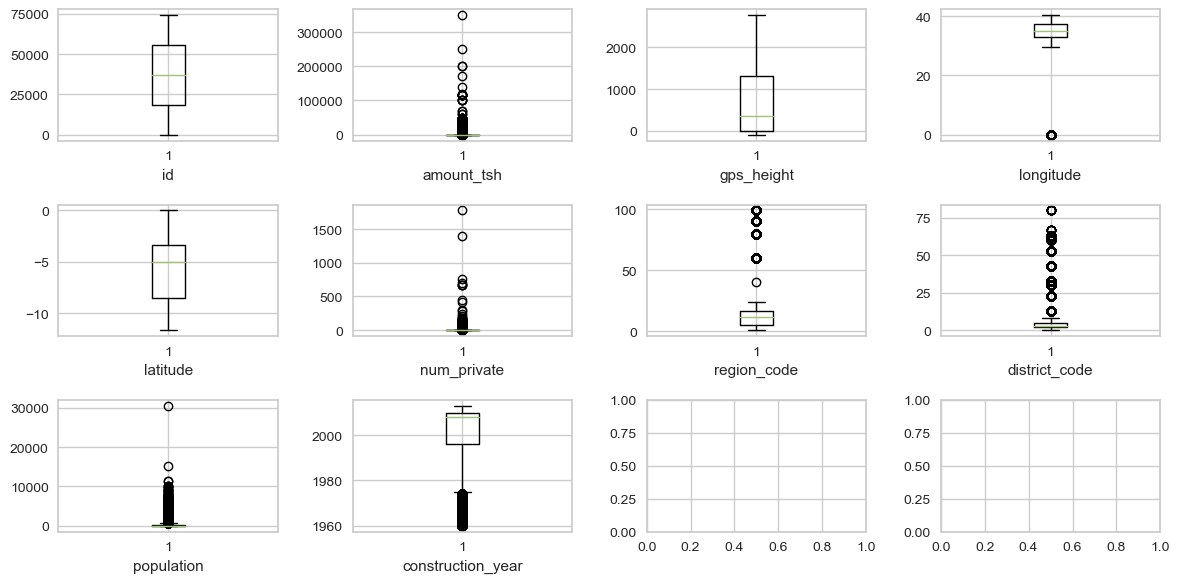

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 6))

for i, column in enumerate(col_nums):
    row, col = np.unravel_index(i, (3, 4))
    
    axes[row, col].boxplot(df_test_train[column], vert=True)
    axes[row, col].set_xlabel(column)


plt.tight_layout()
plt.show()


### Vamos a observar las siguientes variables por datos atípicos: amount_tsh, longitude, num_private, population y construction year.
### Con respecto a las variables region_code, dristrict_code, no vamos a realizar ningún análisis ya que, aunque tengan el tipo numérico no actúan como tal, no cambiamos las variables a categóricas debido a que más adelante tendremos que transformar todas las variables a numéricas.

In [20]:
col_num = ['amount_tsh','longitude','num_private','population', 'construction_year']

for col in col_num:
    print(f"Características de la columna {col}:")
    print(df_test_train[col].value_counts())
    print("-" * 50)

Características de la columna amount_tsh:
amount_tsh
0.0         52049
500.0        3874
50.0         3103
1000.0       1858
20.0         1812
            ...  
250000.0        1
350000.0        1
5400.0          1
53.0            1
0.5             1
Name: count, Length: 102, dtype: int64
--------------------------------------------------
Características de la columna longitude:
longitude
0.000000     2269
37.532095       2
32.993872       2
38.340501       2
37.540805       2
             ... 
34.971223       1
36.744370       1
38.241737       1
37.675430       1
34.765054       1
Name: count, Length: 71870, dtype: int64
--------------------------------------------------
Características de la columna num_private:
num_private
0      73299
1         94
6         92
5         60
8         58
       ...  
136        1
672        1
668        1
698        1
420        1
Name: count, Length: 68, dtype: int64
--------------------------------------------------
Características de la columna p

### De los datos obtenidos vamos a dejar todos los valores como están, como llamativo tenemos: 
    1. En "amount_tsh" encontramos muchos valores que son 0, no los vamos a eliminar debido a que al ser la cantidad de agua disponible en el punto de agua, podría ocurrir que la cantidad fuera cero en algunas regiones, con respecto a los datos atípicos (que según el boxplot son muy elevados) tampoco vamos a realizar ninguna modificación, ya que no sabemos ni siquiera las unidades de medida para poder interpretar el dato como extraordinariamente alto o no.
    2. Con respecto a "longitude", tenemos 2.200 registros con valor atípico que toman la longitud cero, esto es extraño, ya que Tanzania no se encuentra en el ecuador, por tanto no tiene longitud cero, por ahora, al ser pocos registros vamos a dejarlo así, pero podríamos sustituir los ceros por la moda.
    3. Con respecto a la variable "num_private", vemos que casi todos toman el mismo valor que es cero, en la descripción de las variables no aparece un significado de esta variable, por tanto, no podemos ni eliminarla ni realizar ningún tratamiento con los valores atípicos.
    4. Tampoco vamos a realizar ningún tratamiento con los valores atípicos de "Population", ya que como vemos, lo que podría ocurrir es que existieran muchas regiones despobladas, este análisis, además, va en consonancia con la variable "amount_tsh", ya que explicaría por qué los datos elevados son atípicos, ya que correspondería a muchas regiones despobladas con, por tanto, escasa o nula cantidad de agua en los pozos.
    5. Finalmente, con respecto a construction_year, lo más probable es que aparezcan datos atípicos por nuestro tratamiento de los valores cero, por tanto, lo vamos a dejar como está.    

# TRANSOFRMACIÓN DE VARIABLES CATEGÓRICAS A NUMÉRICAS

In [21]:
df_test_train['date_recorded'] = df_test_train['date_recorded'].astype(str).str.split('-').str[0].astype(int)
df_test_train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14846,18990,1000.0,2011,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
14847,28749,0.0,2013,Government Of Tanzania,1476,DWE,34.739804,-4.585587,Bwawani,0,...,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe
14848,33492,0.0,2013,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


In [22]:
var_dummies = ['public_meeting', 'permit']

for variable in var_dummies:
    df_test_train[variable] = df_test_train[variable].astype(int)

df_test_train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,...,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
14846,18990,1000.0,2011,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,...,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
14847,28749,0.0,2013,Government Of Tanzania,1476,DWE,34.739804,-4.585587,Bwawani,0,...,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe
14848,33492,0.0,2013,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,...,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


In [23]:
non_numeric_cols = df_test_train.select_dtypes(exclude=['int', 'float']).columns.tolist()
non_numeric_cols

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'scheme_management',
 'scheme_name',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [24]:
df_label = df_test_train[non_numeric_cols].copy()

le = preprocessing.LabelEncoder()

for columna in df_label.columns:
    le.fit(df_label[columna])
    df_test_train[columna+'_imputada'] = le.transform(df_test_train[columna])

df_test_train = df_test_train.drop(columns=non_numeric_cols)

In [36]:
df_test_train

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,payment_type_imputada,water_quality_imputada,quality_group_imputada,quantity_imputada,quantity_group_imputada,source_imputada,source_type_imputada,source_class_imputada,waterpoint_type_imputada,waterpoint_type_group_imputada
0,69572,6000.0,2011,1390,34.938093,-9.856322,0,11,5,109,...,0,6,2,1,1,8,6,0,1,1
1,8776,0.0,2013,1399,34.698766,-2.147466,0,20,2,280,...,2,6,2,2,2,5,3,1,1,1
2,34310,25.0,2013,686,37.460664,-3.821329,0,21,4,250,...,5,6,2,1,1,0,1,1,2,1
3,67743,0.0,2013,263,38.486161,-11.155298,0,90,63,58,...,2,6,2,0,0,3,0,0,2,1
4,19728,0.0,2011,0,31.130847,-1.825359,0,18,1,0,...,2,6,2,3,3,5,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011,34,38.852669,-6.582841,0,6,1,20,...,2,6,2,1,1,6,4,1,1,1
14846,18990,1000.0,2011,0,37.451633,-5.350428,0,4,7,2960,...,0,4,4,2,2,7,5,0,4,3
14847,28749,0.0,2013,1476,34.739804,-4.585587,0,13,2,200,...,2,6,2,2,2,0,1,1,1,1
14848,33492,0.0,2013,998,35.432732,-10.584159,0,10,2,150,...,2,6,2,2,2,6,4,1,1,1


In [25]:
len_train_x = len(df_train_x)
train_x = df_test_train.iloc[:len_train_x]
test_x = df_test_train.iloc[len_train_x:]

### Comprobamos que hemos dividido correctamente el df con test y train, para ello igualamos los resultados que tenemos en nuestro test_x con los resultados que tenemos en nuestro df_test_x (antes de juntar ambos df), vemos que coinciden todos los valores, por tanto hemos hecho correctamente la partición.

In [26]:
test_x['id'].isin(df_test_x['id']).value_counts()

id
True    14850
Name: count, dtype: int64

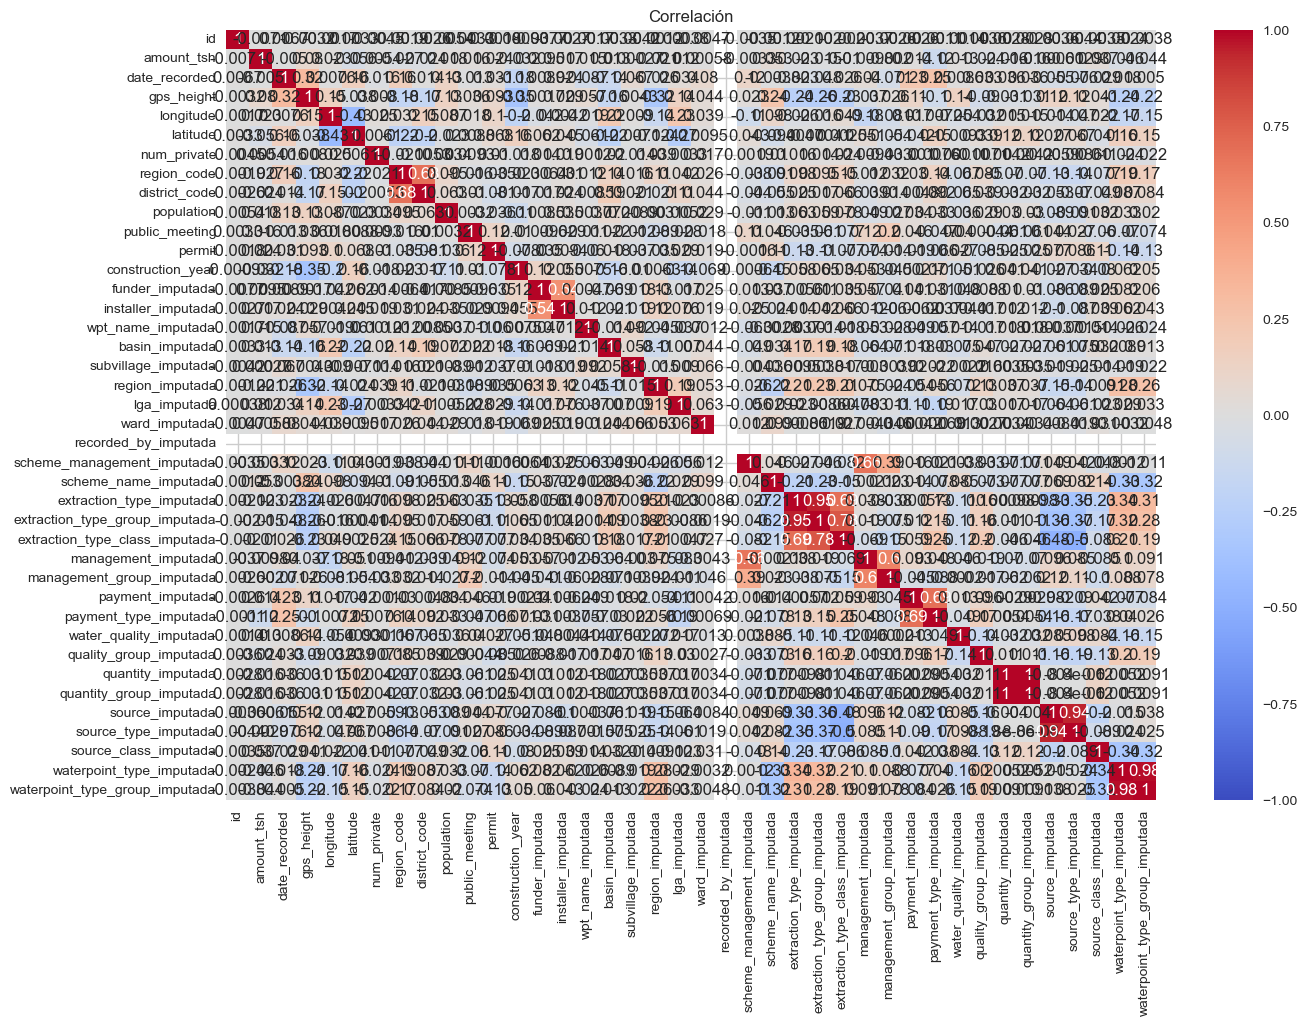

In [27]:
corr_matrix = df_test_train.corr()
    
plt.figure(figsize=(15,10))
    
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    
plt.title('Correlación')
plt.show()

### Puesto que tenemos muchas variables vamos a realizar un mapa de correlaciones en el cual solo veamos aquellas que tienen una correlación mayor a 0,5 en valor absoluto.

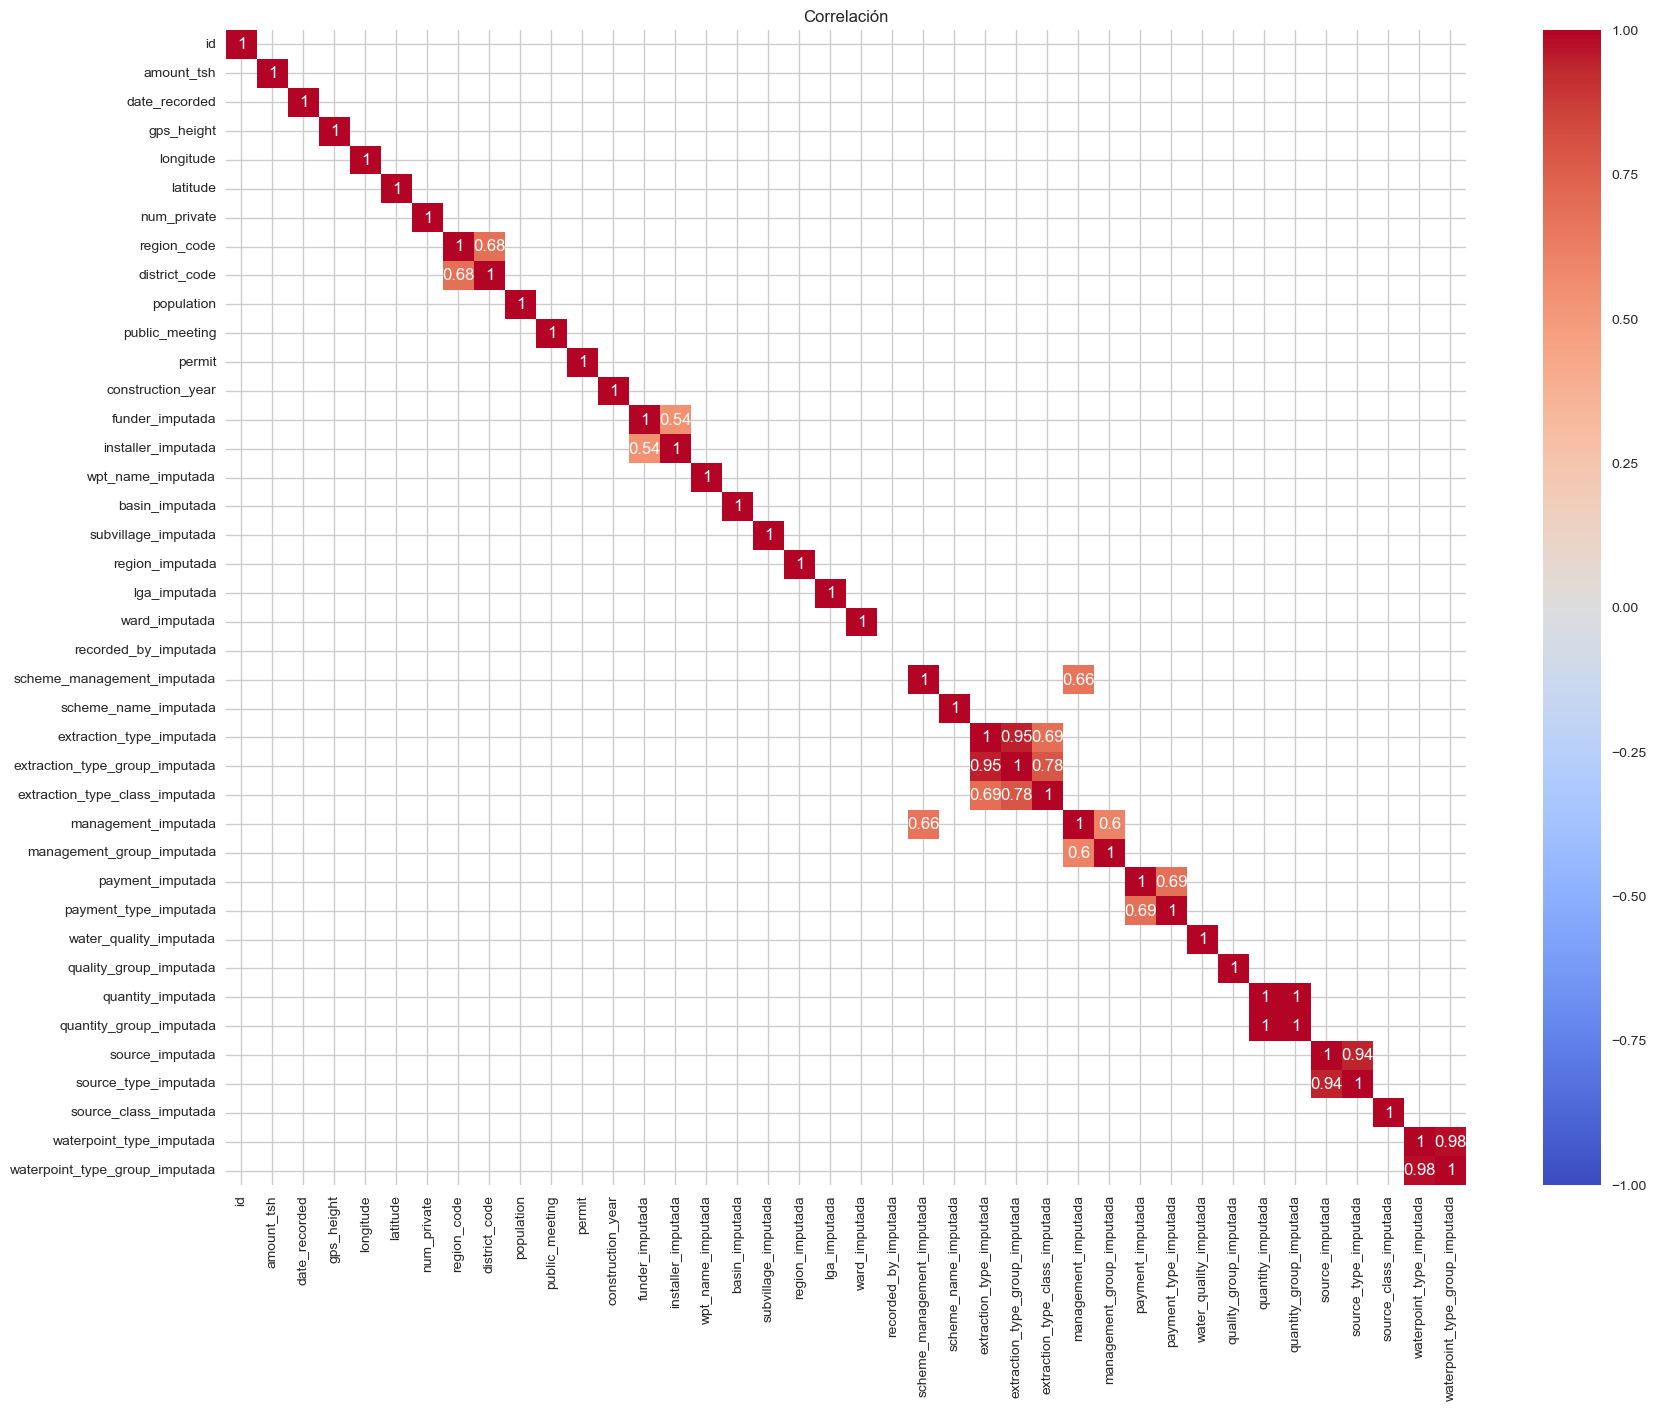

In [28]:
corr_matrix = df_test_train.corr()
    
corr_matrix = corr_matrix[corr_matrix.abs() > 0.5]
    
plt.figure(figsize=(20,15))
    
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    
plt.title('Correlación')
plt.show()

### Una vez que sacamos las correlaciones vemos que las variables que habíamos detectado anteriormente como duplicadas tienen una elevada correlación (como es de esperar), del desto de variables no hay datos especialmente significativos.

### También encontramos una correlación relativamente elevada entre mangement_imputada y recorded_by_imputada. Para ver a qué se puede deber esta correlación vamos a observar ambas variables.

In [29]:
df_train_x[['management','recorded_by']].value_counts()

management        recorded_by            
vwc               GeoData Consultants Ltd    40507
wug               GeoData Consultants Ltd     6515
water board       GeoData Consultants Ltd     2933
wua               GeoData Consultants Ltd     2535
private operator  GeoData Consultants Ltd     1971
parastatal        GeoData Consultants Ltd     1768
water authority   GeoData Consultants Ltd      904
other             GeoData Consultants Ltd      844
company           GeoData Consultants Ltd      685
unknown           GeoData Consultants Ltd      561
other - school    GeoData Consultants Ltd       99
trust             GeoData Consultants Ltd       78
Name: count, dtype: int64

### No observamos que exista tal correlación entre las variables, lo que si observamos es que la variable recorded_by toma el mismo valor para todos los registros, por tanto, podríamos eliminarla, ya que, al mantenerse constante no tendrá influencia en el resultado de la target.

In [30]:
df_merge = pd.concat([train_x, train_y], axis=1)
df_merge = df_merge.loc[:, ~df_merge.columns.duplicated()]

df_merge

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,water_quality_imputada,quality_group_imputada,quantity_imputada,quantity_group_imputada,source_imputada,source_type_imputada,source_class_imputada,waterpoint_type_imputada,waterpoint_type_group_imputada,status_group
0,69572,6000.0,2011,1390,34.938093,-9.856322,0,11,5,109,...,6,2,1,1,8,6,0,1,1,functional
1,8776,0.0,2013,1399,34.698766,-2.147466,0,20,2,280,...,6,2,2,2,5,3,1,1,1,functional
2,34310,25.0,2013,686,37.460664,-3.821329,0,21,4,250,...,6,2,1,1,0,1,1,2,1,functional
3,67743,0.0,2013,263,38.486161,-11.155298,0,90,63,58,...,6,2,0,0,3,0,0,2,1,non functional
4,19728,0.0,2011,0,31.130847,-1.825359,0,18,1,0,...,6,2,3,3,5,3,1,1,1,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013,1210,37.169807,-3.253847,0,3,5,125,...,6,2,1,1,8,6,0,1,1,functional
59396,27263,4700.0,2011,1212,35.249991,-9.070629,0,11,4,56,...,6,2,1,1,6,4,1,1,1,functional
59397,37057,0.0,2011,0,34.017087,-8.750434,0,12,7,0,...,1,1,1,1,3,0,0,4,3,functional
59398,31282,0.0,2011,0,35.861315,-6.378573,0,1,4,0,...,6,2,2,2,7,5,0,4,3,functional


In [43]:
model_setup = setup(data=df_merge, target='status_group', session_id=1)

,Description,Value
0,Session id,1
1,Target,status_group
2,Target type,Multiclass
3,Target mapping,"functional: 0, functional needs repair: 1, non functional: 2"
4,Original data shape,"(59400, 41)"
5,Transformed data shape,"(59400, 41)"
6,Transformed train set shape,"(41580, 41)"
7,Transformed test set shape,"(17820, 41)"
8,Numeric features,40
9,Preprocess,True


### En este caso el preprocesado lo realizaría sustituyendo las variables categóricas por la moda y las variables numéricas por la media, se trata de una sustitución de nulos que podemos tener en cuenta para futuras limpiezas de los datos.

In [41]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8070,0.0000,0.8070,0.8017,0.7994,0.6370,0.6417,2.9710
et,Extra Trees Classifier,0.7995,0.0000,0.7995,0.7936,0.7942,0.6270,0.6292,1.8800
xgboost,Extreme Gradient Boosting,0.7941,0.0000,0.7941,0.7905,0.7825,0.6073,0.6158,1.1690
lightgbm,Light Gradient Boosting Machine,0.7891,0.0000,0.7891,0.7900,0.7749,0.5939,0.6068,1.3230
gbc,Gradient Boosting Classifier,0.7521,0.0000,0.7521,0.7565,0.7313,0.5150,0.5356,15.2660
dt,Decision Tree Classifier,0.7302,0.0000,0.7302,0.7324,0.7312,0.5136,0.5137,0.2920
ada,Ada Boost Classifier,0.7245,0.0000,0.7245,0.7171,0.6993,0.4593,0.4780,1.2940
ridge,Ridge Classifier,0.6538,0.0000,0.6538,0.6077,0.6205,0.3135,0.3290,0.0790
lda,Linear Discriminant Analysis,0.6488,0.0000,0.6488,0.6345,0.6286,0.3188,0.3304,0.1430
lr,Logistic Regression,0.5889,0.0000,0.5889,0.5564,0.5221,0.1465,0.1854,2.5480


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

### Definimos en la variable "status_group" como variables numérica: "0" para las bombas que no funcionan,"1" para las que sí funcionan y "2" para las que necesitan reparación

In [32]:
bombas_num = {"non functional":0, "functional":1, "functional needs repair":2}
df_merge["status_group_imputada"] = df_merge["status_group"]
df_merge["status_group_imputada"].replace(bombas_num, inplace=True)
df_merge.drop('status_group', axis=1, inplace=True)

In [38]:
corr = abs(df_merge.corr())
corr[['status_group_imputada']].sort_values(by = 'status_group_imputada',ascending = False).style.background_gradient()

,status_group_imputada
status_group_imputada,1.000000
waterpoint_type_group_imputada,0.196292
extraction_type_class_imputada,0.195627
waterpoint_type_imputada,0.193195
quality_group_imputada,0.150430
quantity_group_imputada,0.150171
quantity_imputada,0.150171
construction_year,0.137887
extraction_type_group_imputada,0.134387
extraction_type_imputada,0.124155


##### Podríamos eliminar el Id de nuestro DF, sin embargo, puesto que más adelante lo necesitamos para subir los resultados y, además, no tiene casi ninguna relación con la target, no la vamos a eliminar.

### Para evaluar los resultados de nuestro modelo vamos a emplear únicamente los valores de x_train e y_train, estos los vamos a dividir en train y test para poder testear el modelo con nuestro nuevo y_test. 

### Una vez testeado el modelo con este y_test, realizaremos una nueva predicción con el x_test proporiconado en el ejercicio, obteniendo las etiquetas que subiremos a la web.

### Tomo esta decisión porque es la única manera que tengo de testear mi modelo con etiquetas conocidas (ya que no se me proporciona y_test)

In [47]:
x = df_merge.drop(columns="status_group_imputada").values
y = df_merge["status_group_imputada"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= 42)

### Hemos obtenido que el mejor modelo es el Random Forest, así que es el primero que vamos a hacer (con 100 estimadores y sin profundiadd máxima)

In [48]:
modelo_random_forest = RandomForestClassifier(n_estimators=100, max_depth=None).fit(x_train, y_train)

In [49]:
pred_random_forest = modelo_random_forest.predict(x_test)

La precisión del modelo es: [0.85315186 0.80765484 0.56607495]
El accuracy del test del modelo es: 0.8133838383838384
El recall del modelo es: [0.78149606 0.89871457 0.33725029]


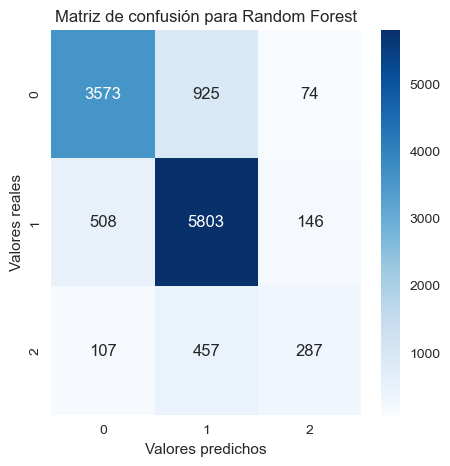

In [50]:
resultado_random_forest = precision_score(y_test, pred_random_forest, average=None)
print("La precisión del modelo es:", resultado_random_forest)

accuracy_random_forest = accuracy_score(y_test, pred_random_forest)
print("El accuracy del test del modelo es:", accuracy_random_forest)

recall_random_forest = recall_score(y_test, pred_random_forest, average=None)
print("El recall del modelo es:", recall_random_forest)

def matriz_confusión (y_true, y_pred, modelo_nombre):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión para {modelo_nombre}")
    plt.ylabel('Valores reales')
    plt.xlabel('Valores predichos')
    plt.show()
    
matriz_confusión(y_test, pred_random_forest, "Random Forest")

### El modelo parece funcionar bastante bien para las clases 0 y 1, con altos valores de precisión y recall. Sin embargo, muestra dificultades significativas para la clase 2, con una precisión y recall considerablemente más bajos. Esto sugiere que el modelo puede necesitar mejoras, especialmente en lo que respecta a la capacidad de identificar correctamente los casos de la clase 2 (funciona pero necesita reparación). 

In [51]:
pred_random_forest = modelo_random_forest.predict(test_x)

In [52]:
test_x['status_group'] = modelo_random_forest.predict(test_x) 

In [53]:
test_x = test_x[['id', 'status_group']].copy()
test_x

,id,status_group
0,50785,0
1,51630,1
2,17168,1
3,45559,0
4,49871,1
...,...,...
14845,39307,0
14846,18990,1
14847,28749,1
14848,33492,1


In [54]:
bombas_num = {0:"non functional", 1:"functional", 2:"functional needs repair"}
test_x["status_group"].replace(bombas_num, inplace=True)

In [55]:
test_x.to_csv('Test_x.csv', index=False)

# ---------------------------SEGUNDO MODELO--------------------------- (0.8169)

### Vamos a realizar un nuevo modelo, en este caso, en la limpieza de datos vamos a eliminar las variables que considerábamos redundantes por estar duplicadas y vamos a cambiar el valor 0 de la longitud por su moda. También eliminamos la variable recorded_by, ya que tomaba el mismo valor para todos los valores

In [58]:
df_test_train

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,payment_type_imputada,water_quality_imputada,quality_group_imputada,quantity_imputada,quantity_group_imputada,source_imputada,source_type_imputada,source_class_imputada,waterpoint_type_imputada,waterpoint_type_group_imputada
0,69572,6000.0,2011,1390,34.938093,-9.856322,0,11,5,109,...,0,6,2,1,1,8,6,0,1,1
1,8776,0.0,2013,1399,34.698766,-2.147466,0,20,2,280,...,2,6,2,2,2,5,3,1,1,1
2,34310,25.0,2013,686,37.460664,-3.821329,0,21,4,250,...,5,6,2,1,1,0,1,1,2,1
3,67743,0.0,2013,263,38.486161,-11.155298,0,90,63,58,...,2,6,2,0,0,3,0,0,2,1
4,19728,0.0,2011,0,31.130847,-1.825359,0,18,1,0,...,2,6,2,3,3,5,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011,34,38.852669,-6.582841,0,6,1,20,...,2,6,2,1,1,6,4,1,1,1
14846,18990,1000.0,2011,0,37.451633,-5.350428,0,4,7,2960,...,0,4,4,2,2,7,5,0,4,3
14847,28749,0.0,2013,1476,34.739804,-4.585587,0,13,2,200,...,2,6,2,2,2,0,1,1,1,1
14848,33492,0.0,2013,998,35.432732,-10.584159,0,10,2,150,...,2,6,2,2,2,6,4,1,1,1


In [31]:
df_test_train2=df_test_train.drop(['source_type_imputada','extraction_type_group_imputada','payment_type_imputada','quality_group_imputada','quantity_group_imputada','waterpoint_type_group_imputada','recorded_by_imputada'], axis=1)
df_test_train2

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,extraction_type_imputada,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada
0,69572,6000.0,2011,1390,34.938093,-9.856322,0,11,5,109,...,3,0,7,4,2,6,1,8,0,1
1,8776,0.0,2013,1399,34.698766,-2.147466,0,20,2,280,...,3,0,11,4,0,6,2,5,1,1
2,34310,25.0,2013,686,37.460664,-3.821329,0,21,4,250,...,3,0,7,4,4,6,1,0,1,2
3,67743,0.0,2013,263,38.486161,-11.155298,0,90,63,58,...,14,5,7,4,0,6,0,3,0,2
4,19728,0.0,2011,0,31.130847,-1.825359,0,18,1,0,...,3,0,1,1,0,6,3,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,2011,34,38.852669,-6.582841,0,6,1,20,...,7,2,7,4,0,6,1,6,1,1
14846,18990,1000.0,2011,0,37.451633,-5.350428,0,4,7,2960,...,8,1,7,4,2,4,2,7,0,4
14847,28749,0.0,2013,1476,34.739804,-4.585587,0,13,2,200,...,3,0,7,4,0,6,2,0,1,1
14848,33492,0.0,2013,998,35.432732,-10.584159,0,10,2,150,...,3,0,7,4,0,6,2,6,1,1


In [32]:
df_test_train2['longitude'].value_counts()
df_test_train2['longitude'].describe()

count    74250.000000
mean        34.074262
std          6.572519
min          0.000000
25%         33.086819
50%         34.907475
75%         37.181685
max         40.345193
Name: longitude, dtype: float64

In [33]:
df_test_train2[df_test_train2['longitude'] == 0.0000]

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,extraction_type_imputada,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada
21,6091,0.0,2013,0,0.0,-2.000000e-08,0,17,1,0,...,15,1,11,4,6,7,4,7,0,4
53,32376,0.0,2011,0,0.0,-2.000000e-08,0,19,6,0,...,14,5,7,4,6,7,0,3,0,2
168,72678,0.0,2013,0,0.0,-2.000000e-08,0,17,1,0,...,3,0,3,2,1,6,3,5,1,1
177,56725,0.0,2013,0,0.0,-2.000000e-08,0,17,1,0,...,9,3,11,4,6,6,1,7,0,6
253,13042,0.0,2012,0,0.0,-2.000000e-08,0,19,2,0,...,8,1,7,4,0,6,2,7,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14649,30454,0.0,2011,0,0.0,-2.000000e-08,0,19,6,0,...,4,1,7,4,0,6,2,7,0,4
14676,44766,0.0,2013,0,0.0,-2.000000e-08,0,17,1,0,...,15,1,11,4,1,6,1,7,0,4
14766,56279,0.0,2012,0,0.0,-2.000000e-08,0,19,2,0,...,3,0,7,4,0,6,2,2,1,2
14831,37994,0.0,2012,0,0.0,-2.000000e-08,0,19,2,0,...,8,1,7,4,0,4,1,7,0,4


In [34]:
columnas_con_valores_incorrectos = ['longitude']  
valor_incorrecto = 0.0000  

for col in columnas_con_valores_incorrectos:
    df_test_train2.loc[df_test_train2[col] == valor_incorrecto, col] = np.nan
    
iter_imputer = IterativeImputer(missing_values=np.nan)
df_test_train_iter = pd.DataFrame(iter_imputer.fit_transform(df_test_train2),
                                     columns=df_test_train2.columns)

df_test_train_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              74250 non-null  float64
 1   amount_tsh                      74250 non-null  float64
 2   date_recorded                   74250 non-null  float64
 3   gps_height                      74250 non-null  float64
 4   longitude                       74250 non-null  float64
 5   latitude                        74250 non-null  float64
 6   num_private                     74250 non-null  float64
 7   region_code                     74250 non-null  float64
 8   district_code                   74250 non-null  float64
 9   population                      74250 non-null  float64
 10  public_meeting                  74250 non-null  float64
 11  permit                          74250 non-null  float64
 12  construction_year               

### Comprobamos que hemos iterado bien los valores cero para mantener la distribución anterior (ya que como no existía un valor moda claro en la variable "longitude", decidimos sustituir los valores de manera que se modificar lo menos posible la distribución de los valores sin contar los nulos). Sería recomendabla hablar también con negocio por si quisiera que estos valores tomaran un valor en particular.

In [35]:
df_test_train_iter['longitude'].describe()

count    74250.000000
mean        35.106152
std          2.582351
min         29.607122
25%         33.283064
50%         34.913015
75%         37.181685
max         40.345193
Name: longitude, dtype: float64

In [36]:
len_train_x = len(df_train_x)
train_x2 = df_test_train_iter.iloc[:len_train_x]
test_x = df_test_train_iter.iloc[len_train_x:]

In [37]:
df_train_x['id'].isin(train_x2['id']).value_counts()

id
True    59400
Name: count, dtype: int64

In [38]:
df_merge2 = pd.concat([train_x2, train_y], axis=1)
df_merge2 = df_merge2.loc[:, ~df_merge2.columns.duplicated()]

df_merge2

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada,status_group
0,69572.0,6000.0,2011.0,1390.0,34.938093,-9.856322,0.0,11.0,5.0,109.0,...,0.0,7.0,4.0,2.0,6.0,1.0,8.0,0.0,1.0,functional
1,8776.0,0.0,2013.0,1399.0,34.698766,-2.147466,0.0,20.0,2.0,280.0,...,0.0,11.0,4.0,0.0,6.0,2.0,5.0,1.0,1.0,functional
2,34310.0,25.0,2013.0,686.0,37.460664,-3.821329,0.0,21.0,4.0,250.0,...,0.0,7.0,4.0,4.0,6.0,1.0,0.0,1.0,2.0,functional
3,67743.0,0.0,2013.0,263.0,38.486161,-11.155298,0.0,90.0,63.0,58.0,...,5.0,7.0,4.0,0.0,6.0,0.0,3.0,0.0,2.0,non functional
4,19728.0,0.0,2011.0,0.0,31.130847,-1.825359,0.0,18.0,1.0,0.0,...,0.0,1.0,1.0,0.0,6.0,3.0,5.0,1.0,1.0,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739.0,10.0,2013.0,1210.0,37.169807,-3.253847,0.0,3.0,5.0,125.0,...,0.0,9.0,4.0,4.0,6.0,1.0,8.0,0.0,1.0,functional
59396,27263.0,4700.0,2011.0,1212.0,35.249991,-9.070629,0.0,11.0,4.0,56.0,...,0.0,7.0,4.0,2.0,6.0,1.0,6.0,1.0,1.0,functional
59397,37057.0,0.0,2011.0,0.0,34.017087,-8.750434,0.0,12.0,7.0,0.0,...,1.0,7.0,4.0,3.0,1.0,1.0,3.0,0.0,4.0,functional
59398,31282.0,0.0,2011.0,0.0,35.861315,-6.378573,0.0,1.0,4.0,0.0,...,1.0,7.0,4.0,0.0,6.0,2.0,7.0,0.0,4.0,functional


In [39]:
bombas_num = {"non functional":0, "functional":1, "functional needs repair":2}
df_merge2["status_group_imputada"] = df_merge2["status_group"]
df_merge2["status_group_imputada"].replace(bombas_num, inplace=True)
df_merge2.drop('status_group', axis=1, inplace=True)

In [69]:
corr = abs(df_merge2.corr())
corr[['status_group_imputada']].sort_values(by = 'status_group_imputada',ascending = False).style.background_gradient()

,status_group_imputada
status_group_imputada,1.000000
extraction_type_class_imputada,0.195627
waterpoint_type_imputada,0.193195
quantity_imputada,0.150171
construction_year,0.137887
extraction_type_imputada,0.124155
source_imputada,0.101744
lga_imputada,0.086445
region_code,0.084491
gps_height,0.079603


In [70]:
model_setup = setup(data=df_merge2, target='status_group_imputada', session_id=1)

,Description,Value
0,Session id,1
1,Target,status_group_imputada
2,Target type,Multiclass
3,Original data shape,"(59400, 34)"
4,Transformed data shape,"(59400, 34)"
5,Transformed train set shape,"(41580, 34)"
6,Transformed test set shape,"(17820, 34)"
7,Numeric features,33
8,Preprocess,True
9,Imputation type,simple


In [38]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8068,0.0000,0.8068,0.8015,0.7991,0.6365,0.6411,2.6590
et,Extra Trees Classifier,0.7975,0.0000,0.7975,0.7913,0.7919,0.6230,0.6253,1.5280
xgboost,Extreme Gradient Boosting,0.7947,0.0000,0.7947,0.7913,0.7832,0.6085,0.6170,1.1140
lightgbm,Light Gradient Boosting Machine,0.7875,0.0000,0.7875,0.7887,0.7733,0.5907,0.6037,1.3030
gbc,Gradient Boosting Classifier,0.7531,0.0000,0.7531,0.7581,0.7323,0.5168,0.5380,14.9770
dt,Decision Tree Classifier,0.7307,0.0000,0.7307,0.7324,0.7315,0.5141,0.5142,0.4200
ada,Ada Boost Classifier,0.7224,0.0000,0.7224,0.7136,0.6968,0.4549,0.4733,1.1390
ridge,Ridge Classifier,0.6444,0.0000,0.6444,0.5971,0.6112,0.2956,0.3095,0.0730
lda,Linear Discriminant Analysis,0.6429,0.0000,0.6429,0.6179,0.6121,0.2943,0.3085,0.0960
lr,Logistic Regression,0.5821,0.0000,0.5821,0.5447,0.5154,0.1331,0.1676,2.6960


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [71]:
x = df_merge2.drop(columns="status_group_imputada").values
y = df_merge2["status_group_imputada"].values

x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.20, random_state= 42)

In [72]:
modelo_random_forest2 = RandomForestClassifier(n_estimators=100, max_depth=None).fit(x_train2, y_train2)

In [73]:
pred_random_forest2 = modelo_random_forest2.predict(x_test2)

La precisión del modelo es: [0.84739336 0.80973636 0.58044807]
El accuracy del test del modelo es: 0.8136363636363636
El recall del modelo es: [0.78215223 0.89902431 0.33490012]


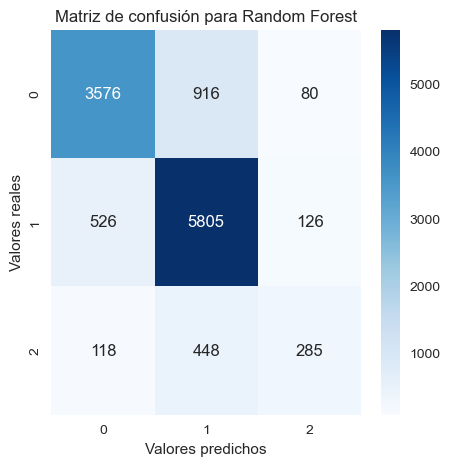

In [74]:
resultado_random_forest2 = precision_score(y_test2, pred_random_forest2, average=None)
print("La precisión del modelo es:", resultado_random_forest2)

accuracy_random_forest2 = accuracy_score(y_test2, pred_random_forest2)
print("El accuracy del test del modelo es:", accuracy_random_forest2)

recall_random_forest2 = recall_score(y_test2, pred_random_forest2, average=None)
print("El recall del modelo es:", recall_random_forest2)

def matriz_confusión (y_true, y_pred, modelo_nombre):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión para {modelo_nombre}")
    plt.ylabel('Valores reales')
    plt.xlabel('Valores predichos')
    plt.show()
    
matriz_confusión(y_test2, pred_random_forest2, "Random Forest")

### Mi modelo sigue prediciendo incorrectamente el caso "Funciona pero necesita reparación" probablemente esto se deba a que el modelo se encuentra desbalanceado, ya que los casos que encontramos en los casos de "No funciona" y "Funciona" son mucho mayores a los datos que encontramos para el caso "Funciona pero necesita reparación"

### Con respecto a la eliminación de las variables duplicadas, no vemos una variación significativa a la hora de predecir los modelos.

In [75]:
test_x2 = test_x

In [76]:
pred_random_forest2 = modelo_random_forest2.predict(test_x2)
test_x2

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,extraction_type_imputada,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada
59400,50785.0,0.0,2013.0,1996.0,35.290799,-4.059696,0.0,21.0,3.0,321.0,...,9.0,3.0,3.0,2.0,0.0,6.0,3.0,5.0,1.0,6.0
59401,51630.0,0.0,2013.0,1569.0,36.656709,-3.309214,0.0,2.0,2.0,300.0,...,3.0,0.0,7.0,4.0,0.0,6.0,2.0,8.0,0.0,1.0
59402,17168.0,0.0,2013.0,1567.0,34.767863,-5.004344,0.0,13.0,2.0,500.0,...,9.0,3.0,7.0,4.0,0.0,6.0,2.0,5.0,1.0,6.0
59403,45559.0,0.0,2013.0,267.0,38.058046,-9.418672,0.0,80.0,43.0,250.0,...,9.0,3.0,7.0,4.0,6.0,6.0,0.0,7.0,0.0,6.0
59404,49871.0,500.0,2013.0,1260.0,35.006123,-10.950412,0.0,10.0,3.0,60.0,...,3.0,0.0,9.0,4.0,3.0,6.0,1.0,8.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,39307.0,0.0,2011.0,34.0,38.852669,-6.582841,0.0,6.0,1.0,20.0,...,7.0,2.0,7.0,4.0,0.0,6.0,1.0,6.0,1.0,1.0
74246,18990.0,1000.0,2011.0,0.0,37.451633,-5.350428,0.0,4.0,7.0,2960.0,...,8.0,1.0,7.0,4.0,2.0,4.0,2.0,7.0,0.0,4.0
74247,28749.0,0.0,2013.0,1476.0,34.739804,-4.585587,0.0,13.0,2.0,200.0,...,3.0,0.0,7.0,4.0,0.0,6.0,2.0,0.0,1.0,1.0
74248,33492.0,0.0,2013.0,998.0,35.432732,-10.584159,0.0,10.0,2.0,150.0,...,3.0,0.0,7.0,4.0,0.0,6.0,2.0,6.0,1.0,1.0


In [77]:
test_x2['status_group'] = modelo_random_forest2.predict(test_x2) 
test_x2


,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada,status_group
59400,50785.0,0.0,2013.0,1996.0,35.290799,-4.059696,0.0,21.0,3.0,321.0,...,3.0,3.0,2.0,0.0,6.0,3.0,5.0,1.0,6.0,0
59401,51630.0,0.0,2013.0,1569.0,36.656709,-3.309214,0.0,2.0,2.0,300.0,...,0.0,7.0,4.0,0.0,6.0,2.0,8.0,0.0,1.0,1
59402,17168.0,0.0,2013.0,1567.0,34.767863,-5.004344,0.0,13.0,2.0,500.0,...,3.0,7.0,4.0,0.0,6.0,2.0,5.0,1.0,6.0,1
59403,45559.0,0.0,2013.0,267.0,38.058046,-9.418672,0.0,80.0,43.0,250.0,...,3.0,7.0,4.0,6.0,6.0,0.0,7.0,0.0,6.0,0
59404,49871.0,500.0,2013.0,1260.0,35.006123,-10.950412,0.0,10.0,3.0,60.0,...,0.0,9.0,4.0,3.0,6.0,1.0,8.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,39307.0,0.0,2011.0,34.0,38.852669,-6.582841,0.0,6.0,1.0,20.0,...,2.0,7.0,4.0,0.0,6.0,1.0,6.0,1.0,1.0,0
74246,18990.0,1000.0,2011.0,0.0,37.451633,-5.350428,0.0,4.0,7.0,2960.0,...,1.0,7.0,4.0,2.0,4.0,2.0,7.0,0.0,4.0,1
74247,28749.0,0.0,2013.0,1476.0,34.739804,-4.585587,0.0,13.0,2.0,200.0,...,0.0,7.0,4.0,0.0,6.0,2.0,0.0,1.0,1.0,1
74248,33492.0,0.0,2013.0,998.0,35.432732,-10.584159,0.0,10.0,2.0,150.0,...,0.0,7.0,4.0,0.0,6.0,2.0,6.0,1.0,1.0,1


In [78]:
bombas_num = {0:"non functional", 1:"functional", 2:"functional needs repair"}
test_x2['status_group'] = test_x2['status_group'].replace(bombas_num)
test_x2

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada,status_group
59400,50785.0,0.0,2013.0,1996.0,35.290799,-4.059696,0.0,21.0,3.0,321.0,...,3.0,3.0,2.0,0.0,6.0,3.0,5.0,1.0,6.0,non functional
59401,51630.0,0.0,2013.0,1569.0,36.656709,-3.309214,0.0,2.0,2.0,300.0,...,0.0,7.0,4.0,0.0,6.0,2.0,8.0,0.0,1.0,functional
59402,17168.0,0.0,2013.0,1567.0,34.767863,-5.004344,0.0,13.0,2.0,500.0,...,3.0,7.0,4.0,0.0,6.0,2.0,5.0,1.0,6.0,functional
59403,45559.0,0.0,2013.0,267.0,38.058046,-9.418672,0.0,80.0,43.0,250.0,...,3.0,7.0,4.0,6.0,6.0,0.0,7.0,0.0,6.0,non functional
59404,49871.0,500.0,2013.0,1260.0,35.006123,-10.950412,0.0,10.0,3.0,60.0,...,0.0,9.0,4.0,3.0,6.0,1.0,8.0,0.0,1.0,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,39307.0,0.0,2011.0,34.0,38.852669,-6.582841,0.0,6.0,1.0,20.0,...,2.0,7.0,4.0,0.0,6.0,1.0,6.0,1.0,1.0,non functional
74246,18990.0,1000.0,2011.0,0.0,37.451633,-5.350428,0.0,4.0,7.0,2960.0,...,1.0,7.0,4.0,2.0,4.0,2.0,7.0,0.0,4.0,functional
74247,28749.0,0.0,2013.0,1476.0,34.739804,-4.585587,0.0,13.0,2.0,200.0,...,0.0,7.0,4.0,0.0,6.0,2.0,0.0,1.0,1.0,functional
74248,33492.0,0.0,2013.0,998.0,35.432732,-10.584159,0.0,10.0,2.0,150.0,...,0.0,7.0,4.0,0.0,6.0,2.0,6.0,1.0,1.0,functional


In [79]:
test_x2 = test_x2[['id', 'status_group']].copy()
test_x2

,id,status_group
59400,50785.0,non functional
59401,51630.0,functional
59402,17168.0,functional
59403,45559.0,non functional
59404,49871.0,functional
...,...,...
74245,39307.0,non functional
74246,18990.0,functional
74247,28749.0,functional
74248,33492.0,functional


In [80]:
test_x2['id'] = test_x2['id'].astype(int)
test_x2

,id,status_group
59400,50785,non functional
59401,51630,functional
59402,17168,functional
59403,45559,non functional
59404,49871,functional
...,...,...
74245,39307,non functional
74246,18990,functional
74247,28749,functional
74248,33492,functional


In [81]:
test_x2.to_csv('Test_x2.csv', index=False)

# ---------------------------TERCER MODELO--------------------------- (0.8154)

# DESBALANCEADO. SOBREMUESTREO

### Vamos a realizar una técnica de sobremuestreo para desbalancear los datos, para ellos se generan más datos de la clase minoritaria para obtener un mayor peso en el modelo.

### Primero vamos a ver qué cantidad de valores hay para cada clase en nuestro df.

In [40]:
df_merge2['status_group_imputada'].value_counts()

status_group_imputada
1    32259
0    22824
2     4317
Name: count, dtype: int64

In [41]:
sm = SMOTE(random_state=2, sampling_strategy='auto')

x_train_res, y_train_res = sm.fit_resample(df_merge2.drop('status_group_imputada', axis=1), df_merge2['status_group_imputada'])

### Comprobamos que no existe sobreajuste del modelo al realizar el sobremuestreo, lo realizamos con la validación cruzada, vemos que en las 5 particiones realizadas el resultado es bastante similar, lo que nos posiciona hacia un no sobreajuste del modelo.

In [42]:
df_merge_res = pd.concat([x_train_res, y_train_res], axis=1)
df_merge_res = df_merge_res.loc[:, ~df_merge_res.columns.duplicated()]

df_merge_res

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada,status_group_imputada
0,69572.000000,6000.000000,2011.000000,1390.000000,34.938093,-9.856322,0.0,11.000000,5.000000,109.000000,...,0.000000,7.000000,4.000000,2.000000,6.0,1.000000,8.000000,0.000000,1.000000,1
1,8776.000000,0.000000,2013.000000,1399.000000,34.698766,-2.147466,0.0,20.000000,2.000000,280.000000,...,0.000000,11.000000,4.000000,0.000000,6.0,2.000000,5.000000,1.000000,1.000000,1
2,34310.000000,25.000000,2013.000000,686.000000,37.460664,-3.821329,0.0,21.000000,4.000000,250.000000,...,0.000000,7.000000,4.000000,4.000000,6.0,1.000000,0.000000,1.000000,2.000000,1
3,67743.000000,0.000000,2013.000000,263.000000,38.486161,-11.155298,0.0,90.000000,63.000000,58.000000,...,5.000000,7.000000,4.000000,0.000000,6.0,0.000000,3.000000,0.000000,2.000000,0
4,19728.000000,0.000000,2011.000000,0.000000,31.130847,-1.825359,0.0,18.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,6.0,3.000000,5.000000,1.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96772,70850.683108,0.000000,2011.000000,0.000000,35.554509,-7.148048,0.0,3.532604,2.151184,0.000000,...,0.230237,7.000000,4.000000,2.690710,6.0,1.000000,7.769763,0.000000,2.460473,2
96773,41271.479012,124.134827,2013.000000,960.850937,36.992773,-3.551842,0.0,2.216948,2.000000,130.474720,...,0.000000,7.433895,4.000000,3.783052,6.0,2.000000,8.000000,0.000000,1.000000,2
96774,27074.853047,0.000000,2011.517538,321.391082,36.272743,-4.336766,0.0,1.517538,1.776307,10.350759,...,0.000000,7.000000,4.000000,1.552614,6.0,1.000000,8.000000,0.000000,1.000000,2
96775,65896.725875,190.134820,2011.760539,389.396111,32.609416,-7.239078,0.0,13.521079,5.478921,136.897070,...,0.000000,9.760539,4.000000,1.140809,6.0,2.239461,6.000000,1.000000,1.380270,2


In [85]:
x = df_merge_res.drop(columns="status_group_imputada").values
y = df_merge_res["status_group_imputada"].values

x_train_res, x_test_res, y_train_res, y_test_res = train_test_split(x, y, test_size=0.20, random_state= 42)

In [86]:
modelo_random_forest_res = RandomForestClassifier(n_estimators=100, max_depth=None).fit(x_train_res, y_train_res)

In [87]:
pred_random_forest_res = modelo_random_forest_res.predict(x_test_res)

La precisión del modelo es: [0.87013447 0.81748036 0.88047445]
El accuracy del test del modelo es: 0.8542570779086588
El recall del modelo es: [0.76271712 0.89097859 0.90923367]


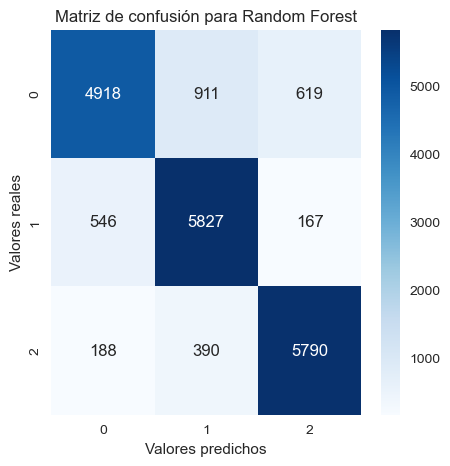

In [88]:
resultado_random_forest_res = precision_score(y_test_res, pred_random_forest_res, average=None)
print("La precisión del modelo es:", resultado_random_forest_res)

accuracy_random_forest_res = accuracy_score(y_test_res, pred_random_forest_res)
print("El accuracy del test del modelo es:", accuracy_random_forest_res)

recall_random_forest_res = recall_score(y_test_res, pred_random_forest_res, average=None)
print("El recall del modelo es:", recall_random_forest_res)

def matriz_confusión (y_true, y_pred, modelo_nombre):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión para {modelo_nombre}")
    plt.ylabel('Valores reales')
    plt.xlabel('Valores predichos')
    plt.show()
    
matriz_confusión(y_test_res, pred_random_forest_res, "Random Forest")

### Comprobamos con el método de validación cruzada que los datos no están sobreajustados

In [89]:
num_folds = 5

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = cross_val_score(modelo_random_forest_res, x_train_res, y_train_res, cv=kf, scoring='accuracy')

for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")

print(f"\nAverage Accuracy: {np.mean(scores):.4f}")

Fold 1: 0.8497
Fold 2: 0.8586
Fold 3: 0.8471
Fold 4: 0.8504
Fold 5: 0.8461

Average Accuracy: 0.8504


### Con los resultado de la validación cruzda, podemos observar que el rendimiento del modelo es igual en las 5 validaciones, eso indica que el modelo probablemente no esté sobreajustado.

In [90]:
test_x = test_x.drop(columns=['status_group'])
test_x

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,extraction_type_imputada,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada
59400,50785.0,0.0,2013.0,1996.0,35.290799,-4.059696,0.0,21.0,3.0,321.0,...,9.0,3.0,3.0,2.0,0.0,6.0,3.0,5.0,1.0,6.0
59401,51630.0,0.0,2013.0,1569.0,36.656709,-3.309214,0.0,2.0,2.0,300.0,...,3.0,0.0,7.0,4.0,0.0,6.0,2.0,8.0,0.0,1.0
59402,17168.0,0.0,2013.0,1567.0,34.767863,-5.004344,0.0,13.0,2.0,500.0,...,9.0,3.0,7.0,4.0,0.0,6.0,2.0,5.0,1.0,6.0
59403,45559.0,0.0,2013.0,267.0,38.058046,-9.418672,0.0,80.0,43.0,250.0,...,9.0,3.0,7.0,4.0,6.0,6.0,0.0,7.0,0.0,6.0
59404,49871.0,500.0,2013.0,1260.0,35.006123,-10.950412,0.0,10.0,3.0,60.0,...,3.0,0.0,9.0,4.0,3.0,6.0,1.0,8.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,39307.0,0.0,2011.0,34.0,38.852669,-6.582841,0.0,6.0,1.0,20.0,...,7.0,2.0,7.0,4.0,0.0,6.0,1.0,6.0,1.0,1.0
74246,18990.0,1000.0,2011.0,0.0,37.451633,-5.350428,0.0,4.0,7.0,2960.0,...,8.0,1.0,7.0,4.0,2.0,4.0,2.0,7.0,0.0,4.0
74247,28749.0,0.0,2013.0,1476.0,34.739804,-4.585587,0.0,13.0,2.0,200.0,...,3.0,0.0,7.0,4.0,0.0,6.0,2.0,0.0,1.0,1.0
74248,33492.0,0.0,2013.0,998.0,35.432732,-10.584159,0.0,10.0,2.0,150.0,...,3.0,0.0,7.0,4.0,0.0,6.0,2.0,6.0,1.0,1.0


In [91]:
pred_random_forest_res = modelo_random_forest_res.predict(test_x)

In [92]:
test_x['status_group'] = modelo_random_forest_res.predict(test_x) 
test_x

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada,status_group
59400,50785.0,0.0,2013.0,1996.0,35.290799,-4.059696,0.0,21.0,3.0,321.0,...,3.0,3.0,2.0,0.0,6.0,3.0,5.0,1.0,6.0,0
59401,51630.0,0.0,2013.0,1569.0,36.656709,-3.309214,0.0,2.0,2.0,300.0,...,0.0,7.0,4.0,0.0,6.0,2.0,8.0,0.0,1.0,1
59402,17168.0,0.0,2013.0,1567.0,34.767863,-5.004344,0.0,13.0,2.0,500.0,...,3.0,7.0,4.0,0.0,6.0,2.0,5.0,1.0,6.0,1
59403,45559.0,0.0,2013.0,267.0,38.058046,-9.418672,0.0,80.0,43.0,250.0,...,3.0,7.0,4.0,6.0,6.0,0.0,7.0,0.0,6.0,0
59404,49871.0,500.0,2013.0,1260.0,35.006123,-10.950412,0.0,10.0,3.0,60.0,...,0.0,9.0,4.0,3.0,6.0,1.0,8.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,39307.0,0.0,2011.0,34.0,38.852669,-6.582841,0.0,6.0,1.0,20.0,...,2.0,7.0,4.0,0.0,6.0,1.0,6.0,1.0,1.0,0
74246,18990.0,1000.0,2011.0,0.0,37.451633,-5.350428,0.0,4.0,7.0,2960.0,...,1.0,7.0,4.0,2.0,4.0,2.0,7.0,0.0,4.0,1
74247,28749.0,0.0,2013.0,1476.0,34.739804,-4.585587,0.0,13.0,2.0,200.0,...,0.0,7.0,4.0,0.0,6.0,2.0,0.0,1.0,1.0,1
74248,33492.0,0.0,2013.0,998.0,35.432732,-10.584159,0.0,10.0,2.0,150.0,...,0.0,7.0,4.0,0.0,6.0,2.0,6.0,1.0,1.0,1


In [93]:
test_x2_res = test_x[['id', 'status_group']].copy()
test_x2_res

,id,status_group
59400,50785.0,0
59401,51630.0,1
59402,17168.0,1
59403,45559.0,0
59404,49871.0,1
...,...,...
74245,39307.0,0
74246,18990.0,1
74247,28749.0,1
74248,33492.0,1


In [94]:
bombas_num = {0:"non functional", 1:"functional", 2:"functional needs repair"}
test_x2_res['status_group'] = test_x2_res['status_group'].replace(bombas_num)
test_x2_res

,id,status_group
59400,50785.0,non functional
59401,51630.0,functional
59402,17168.0,functional
59403,45559.0,non functional
59404,49871.0,functional
...,...,...
74245,39307.0,non functional
74246,18990.0,functional
74247,28749.0,functional
74248,33492.0,functional


In [95]:
test_x2_res['id'] = test_x2_res['id'].astype(int)
test_x2_res

,id,status_group
59400,50785,non functional
59401,51630,functional
59402,17168,functional
59403,45559,non functional
59404,49871,functional
...,...,...
74245,39307,non functional
74246,18990,functional
74247,28749,functional
74248,33492,functional


In [96]:
test_x2_res.to_csv('Test_x2_res.csv', index=False)

# ---------------------------CUARTO MODELO---------------------------(0.8157)

# VAMOS A CREAR UNA VARIABLE ANTIGÜEDAD, COMO TENÍAMOS EL PROBLEMA DE LAS FECHAS, VAMOS A CONVERTIR TODAS LAS FECHAS "DATE_RECORDED" A LA ÚLTIMA FECHA POSIBLE, DE ESTA MANERA MANTENDREMOS LA ANTIGÜEDAD DE LAS BOMBAS, QUE ES EL OBJETIVO DE LA VARIABLE.

In [43]:
df_train_x['date_recorded'].max()

'2013-12-03'

In [44]:
df_test_train_ant = df_merge_res

In [45]:
df_test_train_ant['date_recorded']=2013

In [46]:
df_test_train_ant['antiguedad'] = df_test_train_ant['date_recorded']-df_test_train_ant['construction_year']

In [52]:
df_test_train_ant['antiguedad']= df_test_train_ant['antiguedad'].astype(int)
df_test_train_ant

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada,status_group_imputada,antiguedad
0,69572.000000,6000.000000,2013,1390.000000,34.938093,-9.856322,0.0,11.000000,5.000000,109.000000,...,7.000000,4.000000,2.000000,6.0,1.000000,8.000000,0.000000,1.000000,1,14
1,8776.000000,0.000000,2013,1399.000000,34.698766,-2.147466,0.0,20.000000,2.000000,280.000000,...,11.000000,4.000000,0.000000,6.0,2.000000,5.000000,1.000000,1.000000,1,3
2,34310.000000,25.000000,2013,686.000000,37.460664,-3.821329,0.0,21.000000,4.000000,250.000000,...,7.000000,4.000000,4.000000,6.0,1.000000,0.000000,1.000000,2.000000,1,4
3,67743.000000,0.000000,2013,263.000000,38.486161,-11.155298,0.0,90.000000,63.000000,58.000000,...,7.000000,4.000000,0.000000,6.0,0.000000,3.000000,0.000000,2.000000,0,27
4,19728.000000,0.000000,2013,0.000000,31.130847,-1.825359,0.0,18.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,6.0,3.000000,5.000000,1.000000,1.000000,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96772,70850.683108,0.000000,2013,0.000000,35.554509,-7.148048,0.0,3.532604,2.151184,0.000000,...,7.000000,4.000000,2.690710,6.0,1.000000,7.769763,0.000000,2.460473,2,3
96773,41271.479012,124.134827,2013,960.850937,36.992773,-3.551842,0.0,2.216948,2.000000,130.474720,...,7.433895,4.000000,3.783052,6.0,2.000000,8.000000,0.000000,1.000000,2,34
96774,27074.853047,0.000000,2013,321.391082,36.272743,-4.336766,0.0,1.517538,1.776307,10.350759,...,7.000000,4.000000,1.552614,6.0,1.000000,8.000000,0.000000,1.000000,2,12
96775,65896.725875,190.134820,2013,389.396111,32.609416,-7.239078,0.0,13.521079,5.478921,136.897070,...,9.760539,4.000000,1.140809,6.0,2.239461,6.000000,1.000000,1.380270,2,4


In [54]:
df_test_train_ant2 = df_test_train_ant.drop(['date_recorded','construction_year'], axis=1)

In [58]:
model_setup = setup(data=df_test_train_ant2, target='status_group_imputada', session_id=1)

,Description,Value
0,Session id,1
1,Target,status_group_imputada
2,Target type,Multiclass
3,Original data shape,"(96777, 33)"
4,Transformed data shape,"(96777, 33)"
5,Transformed train set shape,"(67743, 33)"
6,Transformed test set shape,"(29034, 33)"
7,Numeric features,32
8,Preprocess,True
9,Imputation type,simple


In [75]:
corr = abs(df_test_train_ant2.corr())
corr[['status_group_imputada']].sort_values(by = 'status_group_imputada',ascending = False).style.background_gradient()

,status_group_imputada
status_group_imputada,1.000000
extraction_type_class_imputada,0.251999
quantity_imputada,0.195845
waterpoint_type_imputada,0.190834
extraction_type_imputada,0.164204
source_class_imputada,0.155960
longitude,0.150680
lga_imputada,0.129143
source_imputada,0.121038
scheme_management_imputada,0.111635


In [76]:
x = df_test_train_ant2.drop(columns="status_group_imputada").values
y = df_test_train_ant2["status_group_imputada"].values

x_train_ant, x_test_ant, y_train_ant, y_test_ant = train_test_split(x, y, test_size=0.20, random_state= 42)

In [77]:
modelo_random_forest_ant = RandomForestClassifier(n_estimators=100, max_depth=None).fit(x_train_ant, y_train_ant)

In [78]:
pred_random_forest_ant = modelo_random_forest_ant.predict(x_test_ant)

La precisión del modelo es: [0.86931217 0.81703558 0.87950519]
El accuracy del test del modelo es: 0.853482124405869
El recall del modelo es: [0.76442308 0.89174312 0.90436558]


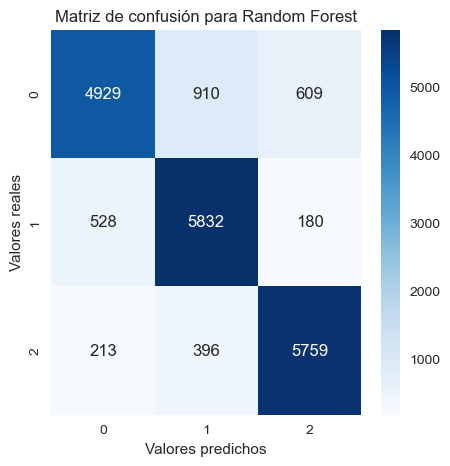

In [79]:
resultado_random_forest_ant = precision_score(y_test_ant, pred_random_forest_ant, average=None)
print("La precisión del modelo es:", resultado_random_forest_ant)

accuracy_random_forest_ant = accuracy_score(y_test_ant, pred_random_forest_ant)
print("El accuracy del test del modelo es:", accuracy_random_forest_ant)

recall_random_forest_ant = recall_score(y_test_ant, pred_random_forest_ant, average=None)
print("El recall del modelo es:", recall_random_forest_ant)

def matriz_confusión (y_true, y_pred, modelo_nombre):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusión para {modelo_nombre}")
    plt.ylabel('Valores reales')
    plt.xlabel('Valores predichos')
    plt.show()
    
matriz_confusión(y_test_ant, pred_random_forest_ant, "Random Forest")

In [80]:
test_x['date_recorded']=2013

In [81]:
test_x['antiguedad'] = test_x['date_recorded']-test_x['construction_year']
test_x

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada,antiguedad
59400,50785.0,0.0,2013,1996.0,35.290799,-4.059696,0.0,21.0,3.0,321.0,...,3.0,3.0,2.0,0.0,6.0,3.0,5.0,1.0,6.0,1.0
59401,51630.0,0.0,2013,1569.0,36.656709,-3.309214,0.0,2.0,2.0,300.0,...,0.0,7.0,4.0,0.0,6.0,2.0,8.0,0.0,1.0,13.0
59402,17168.0,0.0,2013,1567.0,34.767863,-5.004344,0.0,13.0,2.0,500.0,...,3.0,7.0,4.0,0.0,6.0,2.0,5.0,1.0,6.0,3.0
59403,45559.0,0.0,2013,267.0,38.058046,-9.418672,0.0,80.0,43.0,250.0,...,3.0,7.0,4.0,6.0,6.0,0.0,7.0,0.0,6.0,26.0
59404,49871.0,500.0,2013,1260.0,35.006123,-10.950412,0.0,10.0,3.0,60.0,...,0.0,9.0,4.0,3.0,6.0,1.0,8.0,0.0,1.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,39307.0,0.0,2013,34.0,38.852669,-6.582841,0.0,6.0,1.0,20.0,...,2.0,7.0,4.0,0.0,6.0,1.0,6.0,1.0,1.0,25.0
74246,18990.0,1000.0,2013,0.0,37.451633,-5.350428,0.0,4.0,7.0,2960.0,...,1.0,7.0,4.0,2.0,4.0,2.0,7.0,0.0,4.0,19.0
74247,28749.0,0.0,2013,1476.0,34.739804,-4.585587,0.0,13.0,2.0,200.0,...,0.0,7.0,4.0,0.0,6.0,2.0,0.0,1.0,1.0,3.0
74248,33492.0,0.0,2013,998.0,35.432732,-10.584159,0.0,10.0,2.0,150.0,...,0.0,7.0,4.0,0.0,6.0,2.0,6.0,1.0,1.0,4.0


In [82]:
test_x_ant=test_x.drop(['date_recorded','construction_year'], axis=1)

In [83]:
test_x_ant['antiguedad']= test_x_ant['antiguedad'].astype(int)
test_x_ant

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,...,extraction_type_class_imputada,management_imputada,management_group_imputada,payment_imputada,water_quality_imputada,quantity_imputada,source_imputada,source_class_imputada,waterpoint_type_imputada,antiguedad
59400,50785.0,0.0,1996.0,35.290799,-4.059696,0.0,21.0,3.0,321.0,1.0,...,3.0,3.0,2.0,0.0,6.0,3.0,5.0,1.0,6.0,1
59401,51630.0,0.0,1569.0,36.656709,-3.309214,0.0,2.0,2.0,300.0,1.0,...,0.0,7.0,4.0,0.0,6.0,2.0,8.0,0.0,1.0,13
59402,17168.0,0.0,1567.0,34.767863,-5.004344,0.0,13.0,2.0,500.0,1.0,...,3.0,7.0,4.0,0.0,6.0,2.0,5.0,1.0,6.0,3
59403,45559.0,0.0,267.0,38.058046,-9.418672,0.0,80.0,43.0,250.0,1.0,...,3.0,7.0,4.0,6.0,6.0,0.0,7.0,0.0,6.0,26
59404,49871.0,500.0,1260.0,35.006123,-10.950412,0.0,10.0,3.0,60.0,1.0,...,0.0,9.0,4.0,3.0,6.0,1.0,8.0,0.0,1.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74245,39307.0,0.0,34.0,38.852669,-6.582841,0.0,6.0,1.0,20.0,1.0,...,2.0,7.0,4.0,0.0,6.0,1.0,6.0,1.0,1.0,25
74246,18990.0,1000.0,0.0,37.451633,-5.350428,0.0,4.0,7.0,2960.0,1.0,...,1.0,7.0,4.0,2.0,4.0,2.0,7.0,0.0,4.0,19
74247,28749.0,0.0,1476.0,34.739804,-4.585587,0.0,13.0,2.0,200.0,1.0,...,0.0,7.0,4.0,0.0,6.0,2.0,0.0,1.0,1.0,3
74248,33492.0,0.0,998.0,35.432732,-10.584159,0.0,10.0,2.0,150.0,1.0,...,0.0,7.0,4.0,0.0,6.0,2.0,6.0,1.0,1.0,4


In [84]:
pred_random_forest_ant = modelo_random_forest_ant.predict(test_x_ant)

In [85]:
test_x_ant['status_group'] = modelo_random_forest_ant.predict(test_x_ant) 

In [86]:
test_x_ant = test_x_ant[['id', 'status_group']].copy()
test_x_ant

,id,status_group
59400,50785.0,0
59401,51630.0,1
59402,17168.0,1
59403,45559.0,0
59404,49871.0,1
...,...,...
74245,39307.0,0
74246,18990.0,1
74247,28749.0,1
74248,33492.0,1


In [87]:
test_x_ant['id'] = test_x_ant['id'].astype(int)
test_x_ant

,id,status_group
59400,50785,0
59401,51630,1
59402,17168,1
59403,45559,0
59404,49871,1
...,...,...
74245,39307,0
74246,18990,1
74247,28749,1
74248,33492,1


In [89]:
bombas_num = {0:"non functional", 1:"functional", 2:"functional needs repair"}
test_x_ant["status_group"].replace(bombas_num, inplace=True)

In [90]:
test_x_ant.to_csv('Test_x_ant.csv', index=False)